In this notebook, we exemplify the utility of the backtesting engine on the backtesting of the MACD strategy

In [1]:
import pandas as pd 
import talib #Technical Indicator Library


# The MACD's popularity is largely due to its ability to help quickly spot increasing short-term momentum.
# Traders will commonly rely on the default settings of 12- and 26-day periods.
# signal line = MACDsignal
# MACD - signal line = MACDhist
FAST_PERIOD = 12 # Default for traders
SLOW_PERIOD = 26 # Default for traders
SIGNAL_PERIOD = 9 # Default for traders
NEUTRAL_THRESHOLD = 0.1 # The difference between signal line and MACD has to be at least this big to provoke a buy or sell signal

class MACD:

    def __init__(self, df):
        self.df = df.copy(deep=False)
        MACD, MACDsignal, MACDhist = talib.MACD(df['Close'], fastperiod=FAST_PERIOD, slowperiod=SLOW_PERIOD, signalperiod=SIGNAL_PERIOD)
        self.MACD = MACD 
        self.MACDsignal = MACDsignal
        self.MACDhist = MACDhist

    def makeRecommendation(self):
        x = self.MACDhist.iloc[-1] #Most recent MACDhisst 
        if x > NEUTRAL_THRESHOLD:
            return 0 # Bullish 
        elif x < -NEUTRAL_THRESHOLD:
            return 1 # Bearish
        else: 
            return 2 #Netural

In [2]:
#!pip install yfinance
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
from pandas_datareader import data as pdr

def data_strat(stocks, start_date, end_date = []):
    df_data = pd.DataFrame()
    df_data_MACD = pd.DataFrame()
    for stock_name in stocks:
        yf.pdr_override()
        
        # First we compute the data with just the trading dates:

        # Start date:
        start_year, start_month, start_day = start_date
        start = dt.datetime(start_year,start_month,start_day)

        # End date
        if end_date: 
            end_year, end_month, end_day = end_date
            end = dt.datetime(end_year,end_month,end_day)
        else: # If no data is passed to end_date, we assume it is now 
            end = dt.datetime.now()

        df=pdr.get_data_yahoo(stock_name,start,end)

        # To change index from date to num:
        df = df.reset_index()
        
        # Drop the colums we are not going to use:
        df = df.drop("High",axis=1)
        df = df.drop("Low",axis=1)
        df = df.drop("Volume",axis=1)
        df = df.drop("Open",axis=1)
        df = df.drop("Close",axis=1) # We don't use the Close Price 
        df = df.drop("Adj Close",axis=1) # Nor do we use the Adj Close Price 
        
        
        
        if not df_data.columns.to_list():
            df_data = df
        else:
            df_data = pd.merge(df_data, df, on="Date")
            
        
        # Then we compute the data that needs to be passed to MACD (180 days before). We use 360 becasue 180 natural days 
        # are not 180 trading days but 360 natural days cover 180 trading days that is what we need
        start_MACD = dt.datetime(start_year,start_month,start_day) - dt.timedelta(days=360) # To cover

        # End date
        if end_date: 
            end_year, end_month, end_day = end_date
            end = dt.datetime(end_year,end_month,end_day)
        else: # If no data is passed to end_date, we assume it is now 
            end = dt.datetime.now()

        df_MACD=pdr.get_data_yahoo(stock_name,start_MACD,end)

        # To change index from date to num:
        df_MACD = df_MACD.reset_index()
        
        # Drop the colums we are not going to use:
        df_MACD = df_MACD.drop("High",axis=1)
        df_MACD = df_MACD.drop("Low",axis=1)
        df_MACD = df_MACD.drop("Open",axis=1)
        df_MACD = df_MACD.drop("Volume",axis=1)
        df_MACD = df_MACD.drop("Close",axis=1) # We don't use the Close Price 
        # df_MACD = df_MACD.drop("Adj Close",axis=1) # We now need the Adj Close
        
        df_MACD = df_MACD.rename(columns={"Adj Close":f"{stock_name} Adj Close"})
        
        if not df_data_MACD.columns.to_list():
            df_data_MACD = df_MACD
        else:
            df_data_MACD = pd.merge(df_data_MACD, df_MACD, on="Date")
        
    
    return df_data, df_data_MACD
    
# load_data(["AAPL","AMZN","TSLA"],[2018,1,1]).head() # Example

In [3]:
def MACD_preds(stocks,start_date,end_date=[]):
    df_data, df_MACD = data_strat(stocks,start_date,end_date)
    
    df_preds = df_data.copy()

    for stock in stocks:
        
        for index, row in df_data.iterrows():
            temp_df = df_MACD[df_MACD['Date'] <= row["Date"]] # We use all the days until the date in which to make the pred
            pred = MACD(df=temp_df.rename(columns={f"{stock} Adj Close":"Close"})).makeRecommendation()

            if pred == 0:
                df_preds.loc[index,[f"{stock} Prediction",f"{stock} Strength"]] = [1,100]
            elif pred == 1:
                df_preds.loc[index,[f"{stock} Prediction",f"{stock} Strength"]] = [-1,100]
            elif pred == 2:
                df_preds.loc[index,[f"{stock} Prediction",f"{stock} Strength"]] = [0,100]

    return df_preds

In [15]:
stocks = ["AMZN","AAPL"]
start_date = [2020,1,1]
# end_date = [2020,1,1]
end_date = []
initial_capital = 0
interest_rate = 0.0487

preds_df = MACD_preds(stocks,start_date=start_date,end_date=end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
preds_df

,Date,AMZN Prediction,AMZN Strength,AAPL Prediction,AAPL Strength
0,2018-01-02,-1.0,100.0,-1.0,100.0
1,2018-01-03,0.0,100.0,0.0,100.0
2,2018-01-04,0.0,100.0,0.0,100.0
3,2018-01-05,0.0,100.0,0.0,100.0
4,2018-01-08,1.0,100.0,0.0,100.0
...,...,...,...,...,...
498,2019-12-24,1.0,100.0,1.0,100.0
499,2019-12-26,1.0,100.0,1.0,100.0
500,2019-12-27,1.0,100.0,1.0,100.0
501,2019-12-30,1.0,100.0,1.0,100.0


In [17]:
# !pip install import_ipynb
import import_ipynb
from Backtesting_Engine import backtest

data = backtest(stocks,initial_capital,interest_rate,preds_df,start_date,end_date)
# data.to_excel("data.xlsx")
data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Net profit in the selected period: 7592.009$


,Date,AMZN Open,AMZN Pred num,AMZN Nº of shares,AAPL Open,AAPL Pred num,AAPL Nº of shares,Total Nº of shares,Daily interest ($),Total interest ($),Total money owed ($),Invested money ($),Tomorrow's Available money ($),Daily profit ($),Net profit ($),Capital ($),AMZN Tom's - Tod's open ($),AAPL Tom's - Tod's open ($)
0,2020-01-02,93.750000,1.0,1,74.059998,1.0,1,2,0.000,0.000,167.810,167.512,0.000,-0.298,-0.298,-0.298,-0.525,0.228
1,2020-01-03,93.224998,1.0,2,74.287498,1.0,2,4,0.032,0.032,335.355,332.895,0.000,-2.162,-2.460,-2.460,-0.225,-0.840
2,2020-01-06,93.000000,1.0,3,73.447502,1.0,3,6,0.065,0.097,501.867,510.555,0.000,11.148,8.688,8.688,2.225,1.512
3,2020-01-07,95.224998,1.0,4,74.959999,1.0,4,8,0.097,0.194,672.149,676.768,0.000,-4.069,4.619,4.619,-0.323,-0.670
4,2020-01-08,94.902000,1.0,5,74.290001,1.0,5,10,0.130,0.324,841.471,861.522,0.000,15.433,20.051,20.051,0.592,2.520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,2024-05-24,181.649994,-1.0,45,188.820007,1.0,50,95,1.932,1762.367,10003.311,17672.349,0.000,55.168,7669.038,7669.038,-1.720,2.690
1107,2024-05-28,179.929993,-1.0,44,191.509995,0.0,50,94,1.933,1764.300,9908.640,17475.300,83.326,-19.053,7649.985,7649.985,1.770,-1.900
1108,2024-05-29,181.699997,-1.0,43,189.610001,0.0,50,93,1.915,1766.215,9719.791,17334.330,74.261,38.815,7688.800,7688.800,-0.390,1.150
1109,2024-05-30,181.309998,-1.0,42,190.759995,-1.0,49,91,1.879,1768.094,9377.818,16869.160,102.480,-94.978,7593.822,7593.822,-3.010,0.680


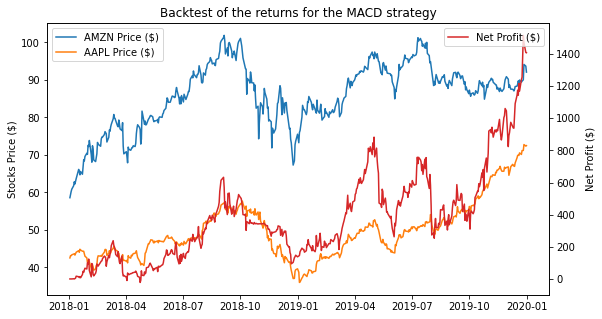

In [11]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(9, 5))
ax1.set_ylabel(f"Stocks Price ($)")
ax1.plot(data["Date"], data[[s + " Open" for s in stocks]], label=[s + " Price ($)" for s in stocks])
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel("Net Profit ($)")
ax2.plot(data["Date"], data["Net profit ($)"], color='tab:red', label="Net Profit ($)")
ax2.legend(loc='upper right')

plt.title("Backtest of the returns following a MACD strategy")
plt.show()
